<a href="https://colab.research.google.com/github/diwakar-vsingh/DeepLabV3-TensorFlow2.x/blob/master/deeplabv3%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DeepLabV3+

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to assign semantic labels to every pixel in an image using Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation. The model is based on TF repo

## Import TensorFlow and other libraries

In [2]:
import tensorflow as tf

import os
import time
import numpy as np
import shutil
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib import gridspec
from IPython import display
from PIL import Image

## Model

In [3]:
img_height = 512
img_width = 512
INPUT_SIZE = 512

WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"

input_shape = (img_height, img_width, 3)
classes = 21
weight = "pascal_voc"

In [4]:
def _depthwise_conv_block(x, filters, prefix, strides=1, rate=1,
                          depth_act=False, epsilon=1e-3):
  
  """
  Adds a depthwise convolution block.
  A depthwise convolution block consists of a depthwise conv,
  batch normalization, relu, pointwise convolution,
  batch normalization and relu activation.
  
  Arguments:
    x: Input tensor
    filters: No. of filters in pointwise convolution
    prefix: prefix before name
    strides: stride at depthwise conv
    rate: atrous rate for depthwise convolution
  Returns:
    Output tensor of block.
  """
  layers = tf.keras.Sequential(name=prefix)
  if not depth_act:
    layers.add(tf.keras.layers.Activation('relu'))

  layers.add(tf.keras.layers.DepthwiseConv2D(3, strides=strides, padding='same', 
                                             use_bias=False, dilation_rate=rate, 
                                             name=prefix+'_depthwise'))
  layers.add(tf.keras.layers.BatchNormalization(epsilon=epsilon, 
                                                name=prefix+"_depthwise_BN"))
  
  if depth_act:
    layers.add(tf.keras.layers.Activation("relu"))
  
  layers.add(tf.keras.layers.Conv2D(filters, 1, strides=1, padding='same', 
                                    use_bias=False, name=prefix+"_pointwise"))
  layers.add(tf.keras.layers.BatchNormalization(epsilon=epsilon,
                                                name=prefix+"_pointwise_BN"))

  if depth_act:
    layers.add(tf.keras.layers.Activation("relu"))

  return layers(x)

def conv_layer(x, filters, kernel, prefix, strides=1, rate=1, epsilon=1e-3, 
               apply_bn=True, depth_act=True, apply_dropout=False, prob=0.1, use_bias=False):
  layers = tf.keras.Sequential(name=prefix)
  
  layers.add(tf.keras.layers.Conv2D(filters, kernel, strides=strides, padding='same', 
                                    use_bias=use_bias, dilation_rate=rate, name=prefix))
  
  if apply_bn:
    layers.add(tf.keras.layers.BatchNormalization(epsilon=epsilon, name=prefix+"_BN"))

  if depth_act:
    layers.add(tf.keras.layers.Activation("relu"))

  if apply_dropout:
    layers.add(tf.keras.layers.Dropout(rate=prob))

  return layers(x)

def ASPP_layers(x, filters, prefix, rate=1, epsilon=1e-5):
  layer = tf.keras.Sequential(
      [
       tf.keras.layers.DepthwiseConv2D(3, padding='same', use_bias=False, 
                                       dilation_rate=rate, name=prefix+"_depthwise"),
       tf.keras.layers.BatchNormalization(epsilon=epsilon, name=prefix+"_depthwise_BN"),
       tf.keras.layers.Activation("relu"),
       tf.keras.layers.Conv2D(filters, 1, padding='same', use_bias=False, 
                              name=prefix+"_pointwise"),
       tf.keras.layers.BatchNormalization(epsilon=epsilon, name=prefix+"_pointwise_BN"),
       tf.keras.layers.Activation("relu")
      ], name=prefix)

  return layer(x)

def image_feature(x, prefix, epsilon=1e-5):
  h, w = x.shape[1:3]
  layer = tf.keras.Sequential(
      [
       tf.keras.layers.AveragePooling2D(pool_size=(h, w)),
       tf.keras.layers.Conv2D(256, 1, padding="same", use_bias=False, name=prefix),
       tf.keras.layers.BatchNormalization(name="image_pooling_BN", epsilon=epsilon),
       tf.keras.layers.Activation("relu"),
       tf.keras.layers.experimental.preprocessing.Resizing(h, w, interpolation='bilinear')       
      ], name=prefix)(x)
   
  return layer

In [5]:
dilation_rates = (1,2)
atrous_rates = (6, 12, 18)

## Encoder
img_input = tf.keras.Input(shape=input_shape)

# Entry flow
x = conv_layer(img_input, 32, 3, "entry_flow_conv1_1", strides=2)
x = conv_layer(x, 64, 3, "entry_flow_conv1_2", strides=1)
residual = conv_layer(x, 128, 1, "entry_flow_block1_shortcut", strides=2, depth_act=False)

# Block 1
x = _depthwise_conv_block(x, 128, "entry_flow_block1_separable_conv1", strides=1)
x = _depthwise_conv_block(x, 128, "entry_flow_block1_separable_conv2", strides=1)
x = _depthwise_conv_block(x, 128, "entry_flow_block1_separable_conv3", strides=2)
x = tf.keras.layers.Add()([x, residual])
residual = conv_layer(x, 256, 1, "entry_flow_block2_shortcut", strides=2, depth_act=False)

# Block 2
x = _depthwise_conv_block(x, 256, "entry_flow_block2_separable_conv1", strides=1)
x = _depthwise_conv_block(x, 256, "entry_flow_block2_separable_conv2", strides=1)
low_level_feat = x
x = _depthwise_conv_block(x, 256, "entry_flow_block2_separable_conv3", strides=2)
x = tf.keras.layers.Add()([x, residual])
residual = conv_layer(x, 728, 1, "entry_flow_block3_shortcut", strides=2, depth_act=False)

# Block 3
x = _depthwise_conv_block(x, 728, "entry_flow_block3_separable_conv1", strides=1)
x = _depthwise_conv_block(x, 728, "entry_flow_block3_separable_conv2", strides=1)
x = _depthwise_conv_block(x, 728, "entry_flow_block3_separable_conv3", strides=2)
x = tf.keras.layers.Add()([x, residual])

# Middle Flow
for i in range(16):
  residual = x
  x = _depthwise_conv_block(x, 728, "middle_flow_unit_%d_separable_conv1" % (i+1))
  x = _depthwise_conv_block(x, 728, "middle_flow_unit_%d_separable_conv2" % (i+1))
  x = _depthwise_conv_block(x, 728, "middle_flow_unit_%d_separable_conv3" % (i+1))
  x = tf.keras.layers.Add()([x, residual])

# Exit Flow
residual = conv_layer(x, 1024, 1, "exit_flow_block1_shortcut", strides=1, depth_act=False)

x = _depthwise_conv_block(x, 728, "exit_flow_block1_separable_conv1", rate=dilation_rates[0])
x = _depthwise_conv_block(x, 1024, "exit_flow_block1_separable_conv2", rate=dilation_rates[0])
x = _depthwise_conv_block(x, 1024, "exit_flow_block1_separable_conv3", rate=dilation_rates[0])
x = tf.keras.layers.Add()([x, residual])

x = _depthwise_conv_block(x, 1536, "exit_flow_block2_separable_conv1", depth_act=True, rate=dilation_rates[1])
x = _depthwise_conv_block(x, 1536, "exit_flow_block2_separable_conv2", depth_act=True, rate=dilation_rates[1])
x = _depthwise_conv_block(x, 2048, "exit_flow_block2_separable_conv3", depth_act=True, rate=dilation_rates[1])

# ASPP module
a0 = conv_layer(x, 256, 1, "aspp0", epsilon=1e-5)
a1 = ASPP_layers(x, 256, "aspp1", rate=atrous_rates[0], epsilon=1e-5)
a2 = ASPP_layers(x, 256, "aspp2", rate=atrous_rates[1], epsilon=1e-5)
a3 = ASPP_layers(x, 256, "aspp3", rate=atrous_rates[2], epsilon=1e-5)
a4 = image_feature(x, "image_pooling", epsilon=1e-5)

x = tf.keras.layers.Concatenate(name="image_feature")([a4, a0, a1, a2, a3])
x = conv_layer(x, 256, 1, "concat_projection", epsilon=1e-5, apply_dropout=True)

## Decoder
x = tf.keras.layers.experimental.preprocessing.Resizing(
    4*x.shape[1], 4*x.shape[2], interpolation='bilinear')(x)

low_level_feat = conv_layer(low_level_feat, 48, 1, "feature_projection0", epsilon=1e-5)
x = tf.keras.layers.Concatenate(name="skip_concat")([x, low_level_feat])
x = _depthwise_conv_block(x, 256, "decoder_conv0", depth_act=True, epsilon=1e-5)
x = _depthwise_conv_block(x, 256, "decoder_conv1", depth_act=True, epsilon=1e-5)

if (weight=='pascal_voc' and classes==21) or (weight=="cityscapes" and classes==19):
  last_layer = "logits_semantic"
else:
  last_layer = "custom_logits_semantic"

x = conv_layer(x, classes, 1, prefix=last_layer, apply_bn=False, 
               depth_act=False, use_bias=True)

x = tf.keras.layers.experimental.preprocessing.Resizing(
    img_height, img_width, interpolation='bilinear')(x)

model = tf.keras.Model(inputs=img_input, outputs=x, name="DeepLabv3Plus")

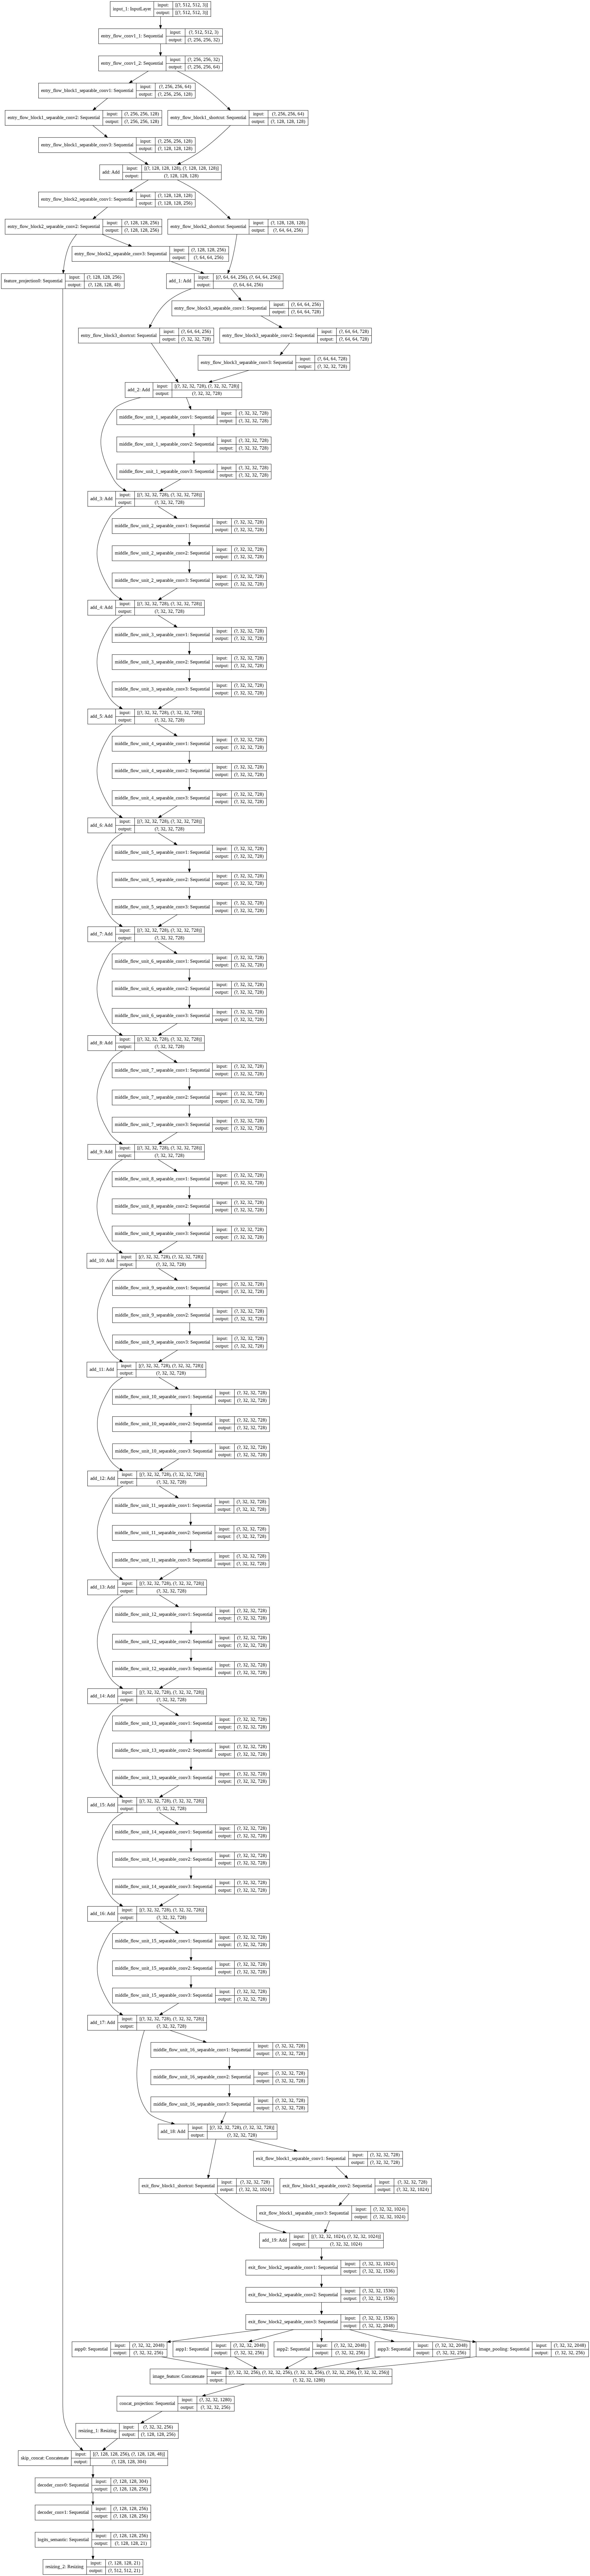

In [6]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [7]:
model.summary(line_length=150)

Model: "DeepLabv3Plus"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 512, 512, 3)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
entry_flow_conv1_1 (Sequential)                  (None, 256, 256, 32)             992               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
entry_flow_conv1_2 (Sequential)                  (None, 256, 256, 64)  

## Extract weight

In [8]:
def get_xception_filename(key):
  """
  Rename tensor name to the corresponding Keras layer weight name.
  # Arguments
    key: tensor name in TF (determined by tf.variable_scope)
  """
  
  filename = str(key)
  filename = filename.replace('/', '_')
  filename = filename.replace('xception_65_', '')
  filename = filename.replace('decoder_', '', 1)
  filename = filename.replace('BatchNorm', 'BN')
  
  if 'Momentum' in filename:
    return None
  
  if 'entry_flow' in filename or 'exit_flow' in filename:
    filename = filename.replace('_unit_1_xception_module', '')
  elif 'middle_flow' in filename:
    filename = filename.replace('_block1', '')
    filename = filename.replace('_xception_module', '')

  # from TF to Keras naming
  filename = filename.replace('_weights', '_kernel')
  filename = filename.replace('_biases', '_bias')

  return filename + '.npy'

def extract_tensors_from_checkpoint_file(filename, output_folder='weights', net_name=None):
    """Extract tensors from a TF checkpoint file.
    # Arguments
        filename: TF checkpoint file
        output_folder: where to save the output numpy array files
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    reader = tf.compat.v1.train.NewCheckpointReader(filename)

    for key in reader.get_variable_to_shape_map():
        # convert tensor name into the corresponding Keras layer weight name and save
        if net_name == 'xception':
            filename = get_xception_filename(key)
        elif net_name == 'mobilenetv2':
            filename = get_mobilenetv2_filename(key)
        if filename:
            path = os.path.join(output_folder, filename)
            arr = reader.get_tensor(key)
            np.save(path, arr)
            # print("tensor_name: ", key)

In [9]:
CKPT_URL = 'http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz'
MODEL_DIR = 'models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

checkpoint_tar = tf.keras.utils.get_file(
    fname='deeplabv3_pascal_trainval_2018_01_04.tar.gz',
    origin=CKPT_URL,
    extract=True,
    cache_subdir='',
    cache_dir=MODEL_DIR)

In [10]:
# shutil.rmtree("weights/xception")

In [11]:
output_folder = 'weights/xception'
net_name = 'xception'

MODEL_SUBDIR = 'deeplabv3_pascal_trainval'
MODEL_SUBDIR_MOBILE = 'deeplabv3_mnv2_pascal_trainval'

checkpoint_file = os.path.join(MODEL_DIR, MODEL_SUBDIR, 'model.ckpt')

extract_tensors_from_checkpoint_file(
    checkpoint_file, net_name='xception', output_folder='weights/xception')

tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv3_pointwise/BatchNorm/moving_variance
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv3_pointwise/BatchNorm/beta
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv3_depthwise/depthwise_weights
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv3_depthwise/BatchNorm/moving_variance
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv3_depthwise/BatchNorm/moving_mean
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv3_depthwise/BatchNorm/beta
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv2_pointwise/BatchNorm/moving_variance
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv2_depthwise/BatchNorm/moving_variance
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separa

## Load weights

In [10]:
MODEL_DIR = 'models'
backbone = 'xception'
# model = Deeplabv3(input_shape=(512, 512, 3), classes=21, backbone=backbone, weights=None)

WEIGHTS_DIR = 'weights/' + backbone
print('Loading weights from', WEIGHTS_DIR)

for layers in model.layers:
  if layers.weights:
    for layer in layers.layers:
      weights = []
      for w in layer.weights:
        weight_name = os.path.basename(w.name).replace(':0', '')
        weight_file = layer.name + '_' + weight_name + '.npy'
        weight_arr = np.load(os.path.join(WEIGHTS_DIR, weight_file))
        weights.append(weight_arr)
      layer.set_weights(weights)

print('Saving model weights...')
OUTPUT_WEIGHT_FILENAME = 'deeplabv3plus_' + backbone + '.h5'

if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)
  
model.save_weights(os.path.join(MODEL_DIR, OUTPUT_WEIGHT_FILENAME))

Loading weights from weights/xception
Saving model weights...


## Make predictions

In [12]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image

def resize_and_normalize(image):
  image = tf.image.resize(image, size=(INPUT_SIZE, INPUT_SIZE))
  image = (image / 127.5) - 1
  image = tf.expand_dims(image, axis=0)
  return image

def inference(image):
  """
  Runs inference on a single image.

  Args:
    image: A PIL.Image object, raw input image.

  Returns:
    resized_image: RGB image resized from original input image.
    seg_map: Segmentation map of `resized_image`.
  """

  height, width, _ = image.shape
  resize_ratio = 1.0 * INPUT_SIZE / max(width, height)
  target_size = (int(resize_ratio * width), int(resize_ratio * height))
  resized_image = resize_and_normalize(image)

  batch_seg_map = model.predict(resized_image)
  seg_map = tf.argmax(logit[0], axis=-1)
  seg_map = tf.image.resize(tf.expand_dims(seg_map, axis=-1), size=(height, width))
  seg_map = tf.squeeze(seg_map)
  seg_map = tf.cast(seg_map, tf.int8)
  
  return resized_image, seg_map

In [105]:
file_name = "image1.jpg"
image = read_image(file_name)
resized_image, seg_map = inference(image)

## Display Results

(-0.5, 639.5, 426.5, -0.5)

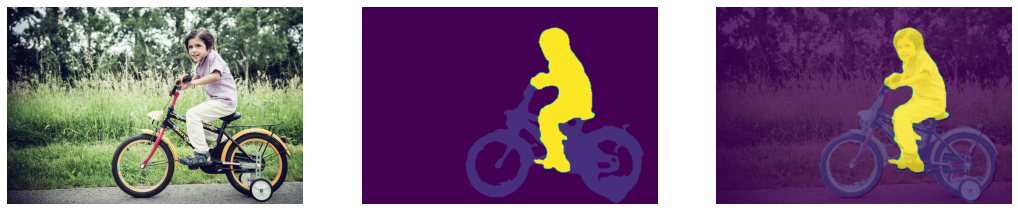

In [59]:
plt.figure(figsize=(18, 12))
plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.axis("Off")

plt.subplot(1, 3, 2)
plt.imshow(labels)
plt.axis("Off")

plt.subplot(1, 3, 3)
plt.imshow(input_img)
plt.imshow(labels, alpha=0.8)
plt.axis("Off")

In [75]:
# Max number of entries in the colormap for each dataset.
_DATASET_MAX_ENTRIES = {
    "cityscape": 256,
    "pascal": 512,
}


def create_cityscapes_label_colormap():
  """Creates a label colormap used in CITYSCAPES segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=np.uint8)
  colormap[0] = [128, 64, 128]
  colormap[1] = [244, 35, 232]
  colormap[2] = [70, 70, 70]
  colormap[3] = [102, 102, 156]
  colormap[4] = [190, 153, 153]
  colormap[5] = [153, 153, 153]
  colormap[6] = [250, 170, 30]
  colormap[7] = [220, 220, 0]
  colormap[8] = [107, 142, 35]
  colormap[9] = [152, 251, 152]
  colormap[10] = [70, 130, 180]
  colormap[11] = [220, 20, 60]
  colormap[12] = [255, 0, 0]
  colormap[13] = [0, 0, 142]
  colormap[14] = [0, 0, 70]
  colormap[15] = [0, 60, 100]
  colormap[16] = [0, 80, 100]
  colormap[17] = [0, 0, 230]
  colormap[18] = [119, 11, 32]
  return colormap


def create_pascal_label_colormap():
  """
  Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A colormap for visualizing segmentation results.
  """

  colormap = np.zeros((_DATASET_MAX_ENTRIES["pascal"], 3), dtype=int)
  ind = np.arange(_DATASET_MAX_ENTRIES["pascal"], dtype=int)

  for shift in reversed(list(range(8))):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label, dataset=_PASCAL):
  """
  Adds color defined by the dataset colormap to the label.
  Args:
    label: A 2D array with integer type, storing the segmentation label.
    dataset: The colormap used in the dataset.
  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the dataset color map.
  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """

  if label.ndim != 2:
    raise ValueError('Expect 2-D input label. Got {}'.format(label.shape))

  if np.max(label) >= _DATASET_MAX_ENTRIES[dataset]:
    raise ValueError(
        'label value too large: {} >= {}.'.format(
            np.max(label), _DATASET_MAX_ENTRIES[dataset]))
  
  if dataset == 'cityscapes':
    return create_cityscapes_label_colormap()[label]

  elif dataset == "pascal":
    return create_pascal_label_colormap()[label]    
  
  else:
    raise ValueError('Unsupported dataset.')


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [100]:
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int8),
 array([219032,   1779,  30327,    110,    131,     76,     43,    114,
            62,     42,     90,     71,     62,    187,    104,  21050]))

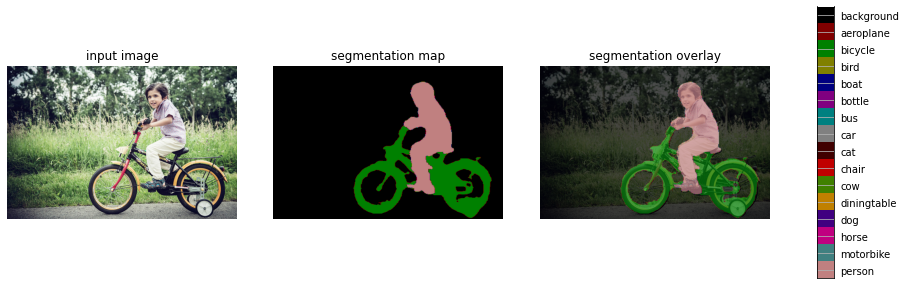

In [96]:
vis_segmentation(input_img, labels)